In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import numpy as np
import warnings

df = pd.read_csv("4015630.csv")
warnings.filterwarnings("ignore")

In [2]:
# taking out unnecessary data
data_df = df.drop(["STATION","NAME","LATITUDE","LONGITUDE","ELEVATION"], axis= 1)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    3774 non-null   object
 1   TAVG    3774 non-null   int64 
 2   TMAX    3774 non-null   int64 
 3   TMIN    3774 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 118.1+ KB


In [3]:
# Discovering the Data
data_df.describe()

,TAVG,TMAX,TMIN
count,3774.000000,3774.000000,3774.000000
mean,47.818495,56.241918,39.263116
std,22.460689,23.700390,21.846995
min,-22.000000,-13.000000,-28.000000
25%,31.000000,37.000000,24.000000
50%,49.000000,58.000000,40.000000
75%,68.000000,78.000000,59.000000
max,90.000000,101.000000,79.000000


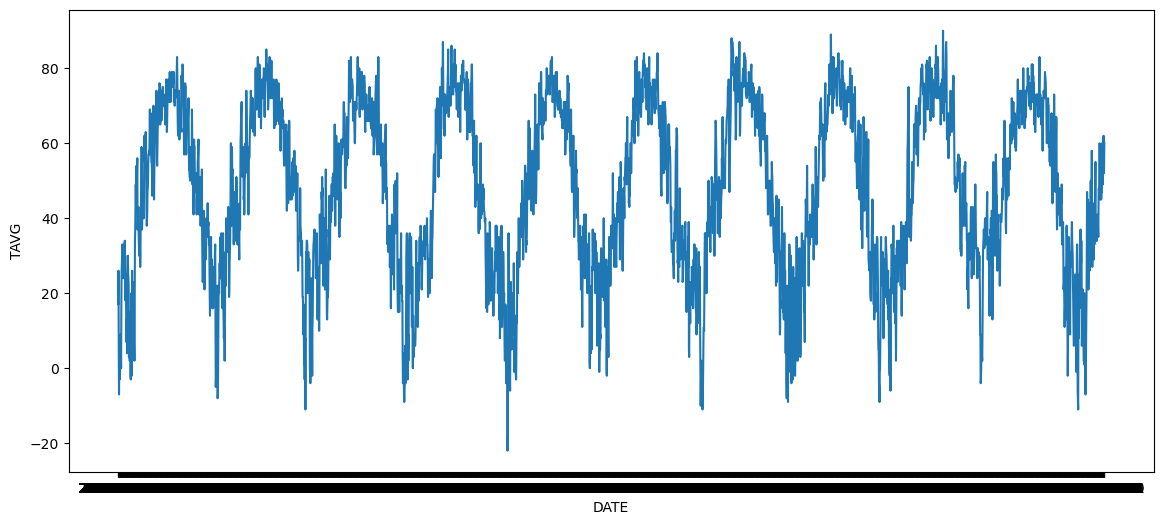

In [8]:
# Visualizing the data (raw average temperature)
plt.figure(figsize=(14, 6))
avg_temp = sns.lineplot(data= data_df, x= "DATE", y= "TAVG")

## Rolling Average Predictions

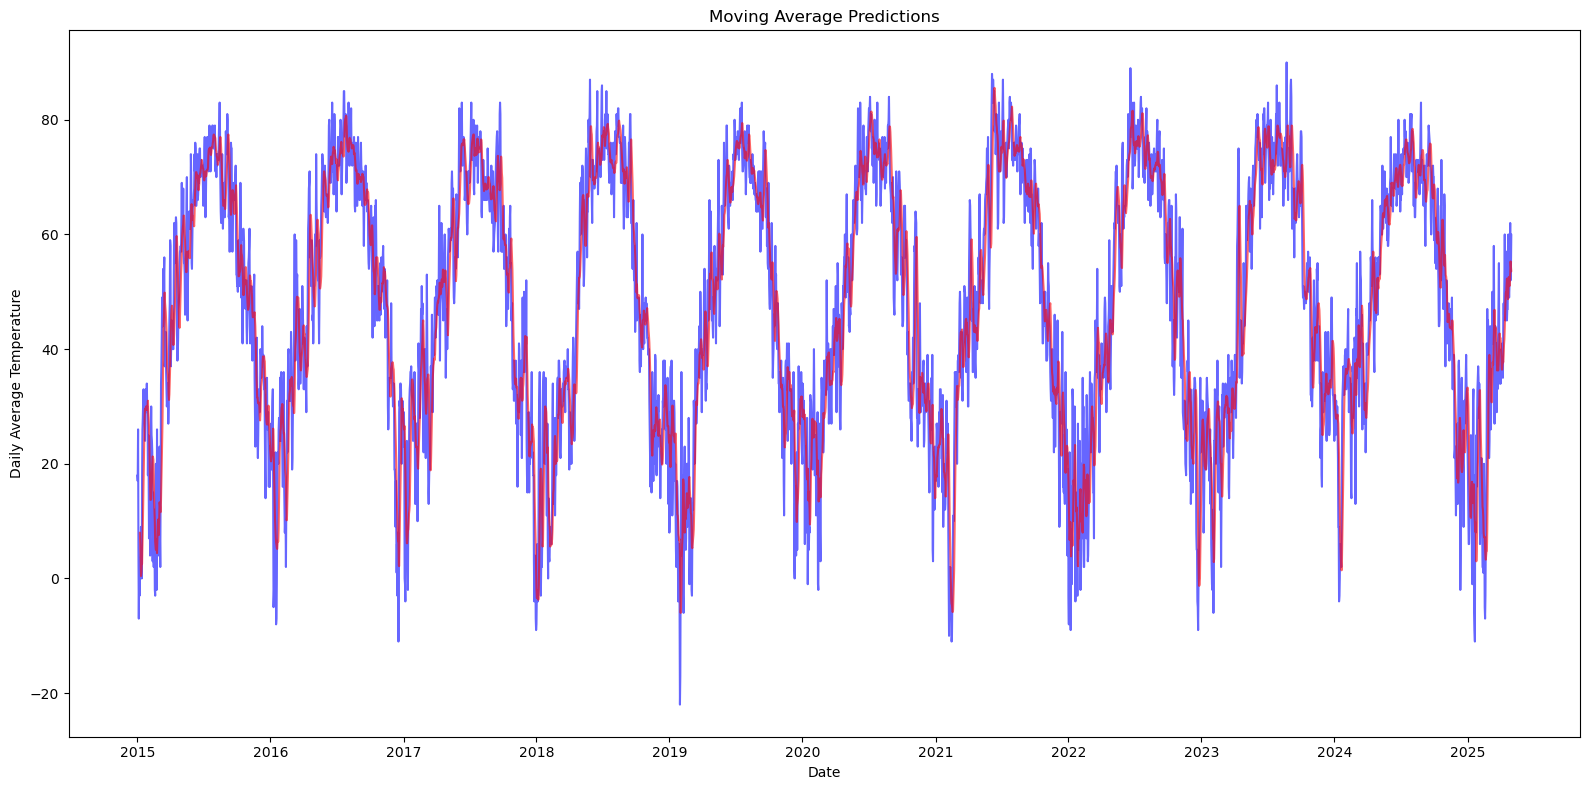

In [50]:
from matplotlib.dates import DateFormatter, YearLocator
# Rolling average prediction
moving_window = 7   # 7 Day moving average
moving_df = data_df.copy()
moving_df['predict'] = data_df['TAVG'].rolling(moving_window).mean().shift(1)

# Preparing Data for Graphing
moving_df['DATE'] = pd.to_datetime(moving_df['DATE'])

# Graph predictions vs actual values
predict_x_avg = (
    so.Plot(moving_df, x= "DATE")
    .add(so.Line(color= "blue", alpha= .6), y= "TAVG")
    .add(so.Line(color= "red", alpha= .6), y= "predict")

    .scale()
    .layout(size= (16, 8))
    .label(x= 'Date', y= "Daily Average Temperature", title= "Moving Average Predictions")
)

fig, ax = plt.subplots(figsize=(16,8))

predict_x_avg.on(ax).plot()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.tight_layout()
plt.show()


## Linear Regression

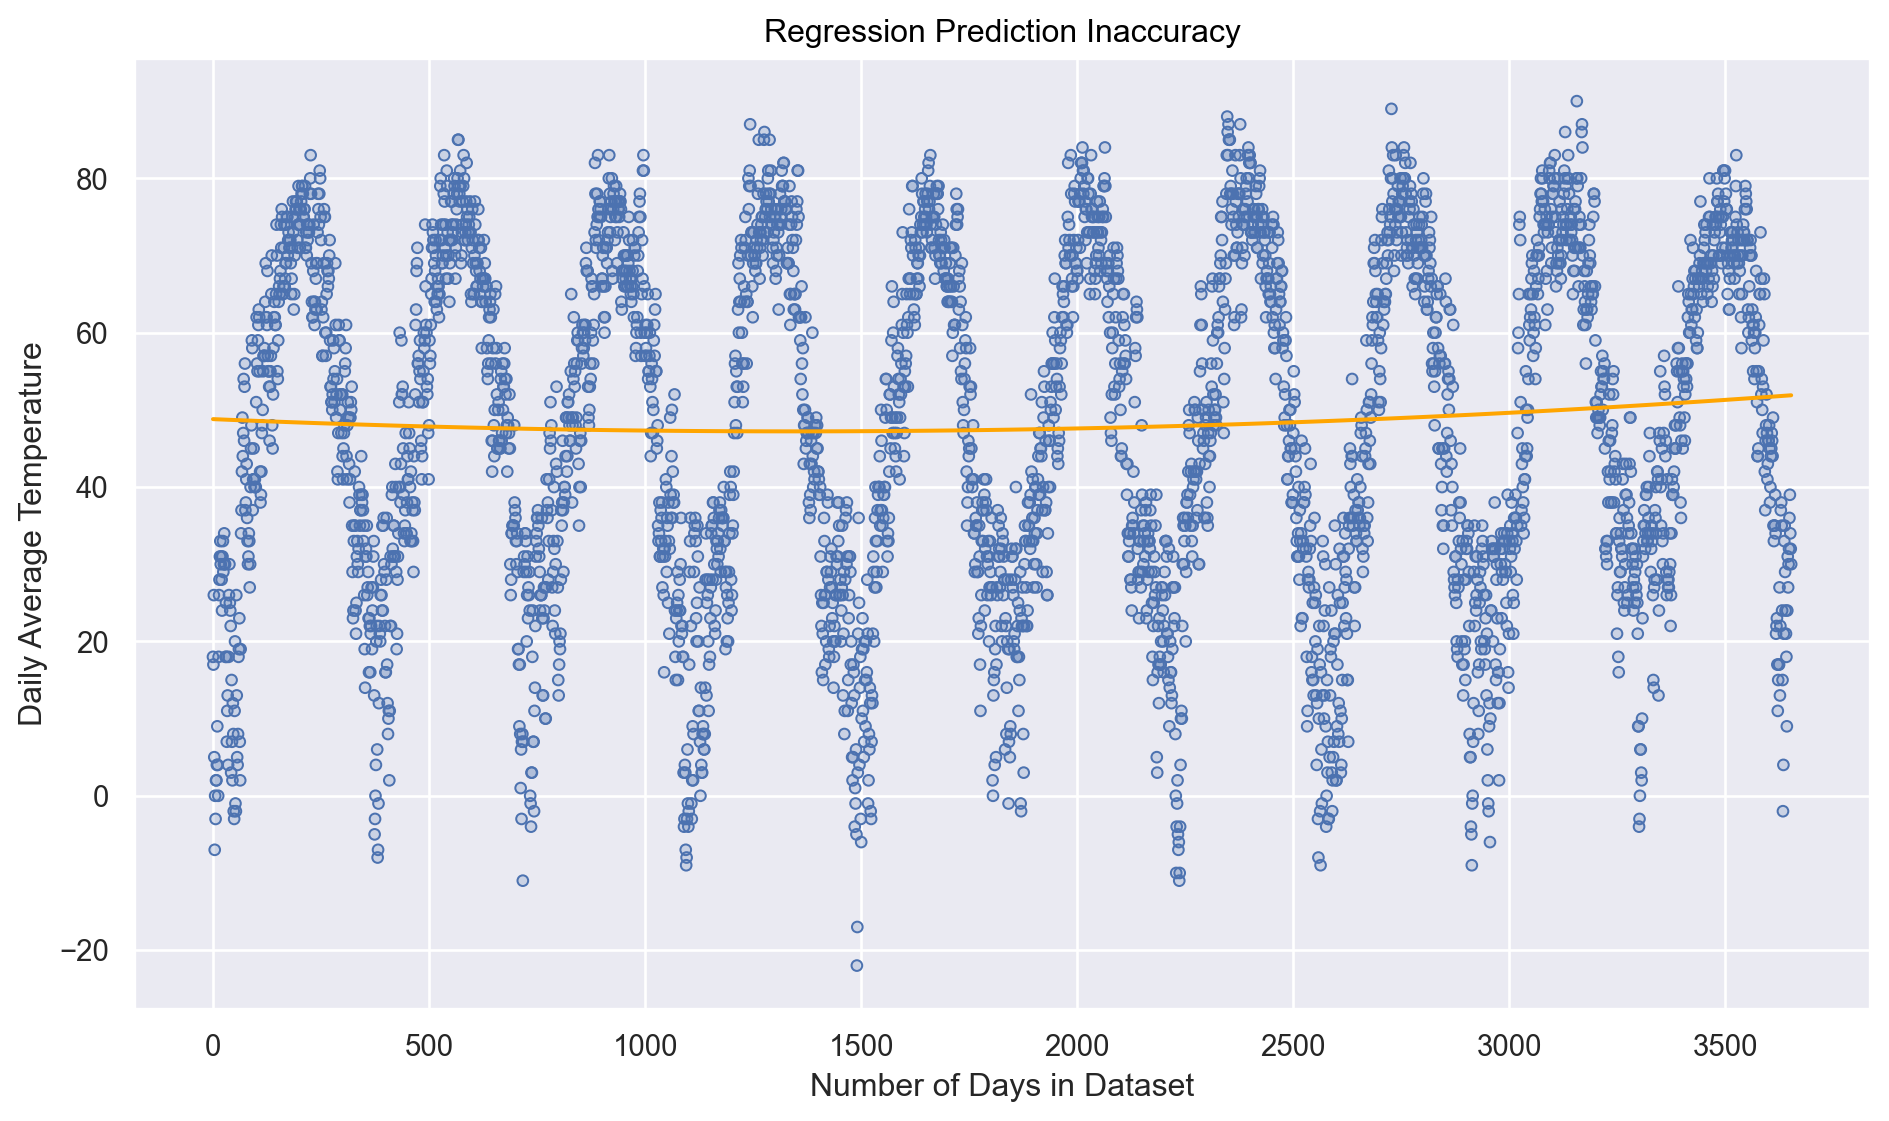

In [4]:
from sklearn.linear_model import LinearRegression

# Functions for pipeline
def to_datetime(df):
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df

def exclude_year(df, excluded_year):
    return df[df['DATE'].dt.year != excluded_year].copy()

def add_day_counter(df):
    df.copy()
    df['Day'] = np.arange(len(df.index))
    return df
# Using pipeline to create usable dataframe
excluded_regr_df = (
    data_df
    .copy()
    .pipe(to_datetime)
    .pipe(exclude_year, 2025)
    .pipe(add_day_counter)
)


ts_X = excluded_regr_df[['Day']]    # Feature Variable
ts_y = excluded_regr_df[['TAVG']]      # Target Variable

ts_model = LinearRegression()
ts_model.fit(ts_X, ts_y)

ts_y_predict = pd.DataFrame(ts_model.predict(ts_X))

# Finding the coefficient and intercept
ts_model.coef_, ts_model.intercept_
# Horrible results as to be expected

plotting_df = pd.DataFrame(
    {"Day": ts_X['Day'].values.flatten(),
     "TAVG": ts_y["TAVG"].values.flatten()}
)

# Showing that the simple regression line is not particularly helpful for this
ts_model_plot = (
    so.Plot(plotting_df, "Day", "TAVG")
    .add(so.Dots())
    .add(so.Line(color= "orange"), so.PolyFit())
    .label(
        x= "Number of Days in Dataset", 
        y= "Daily Average Temperature",
        title= "Regression Prediction Inaccuracy")
    .layout(size=(10,6))
)
ts_model_plot


## Fourier Feature Regression

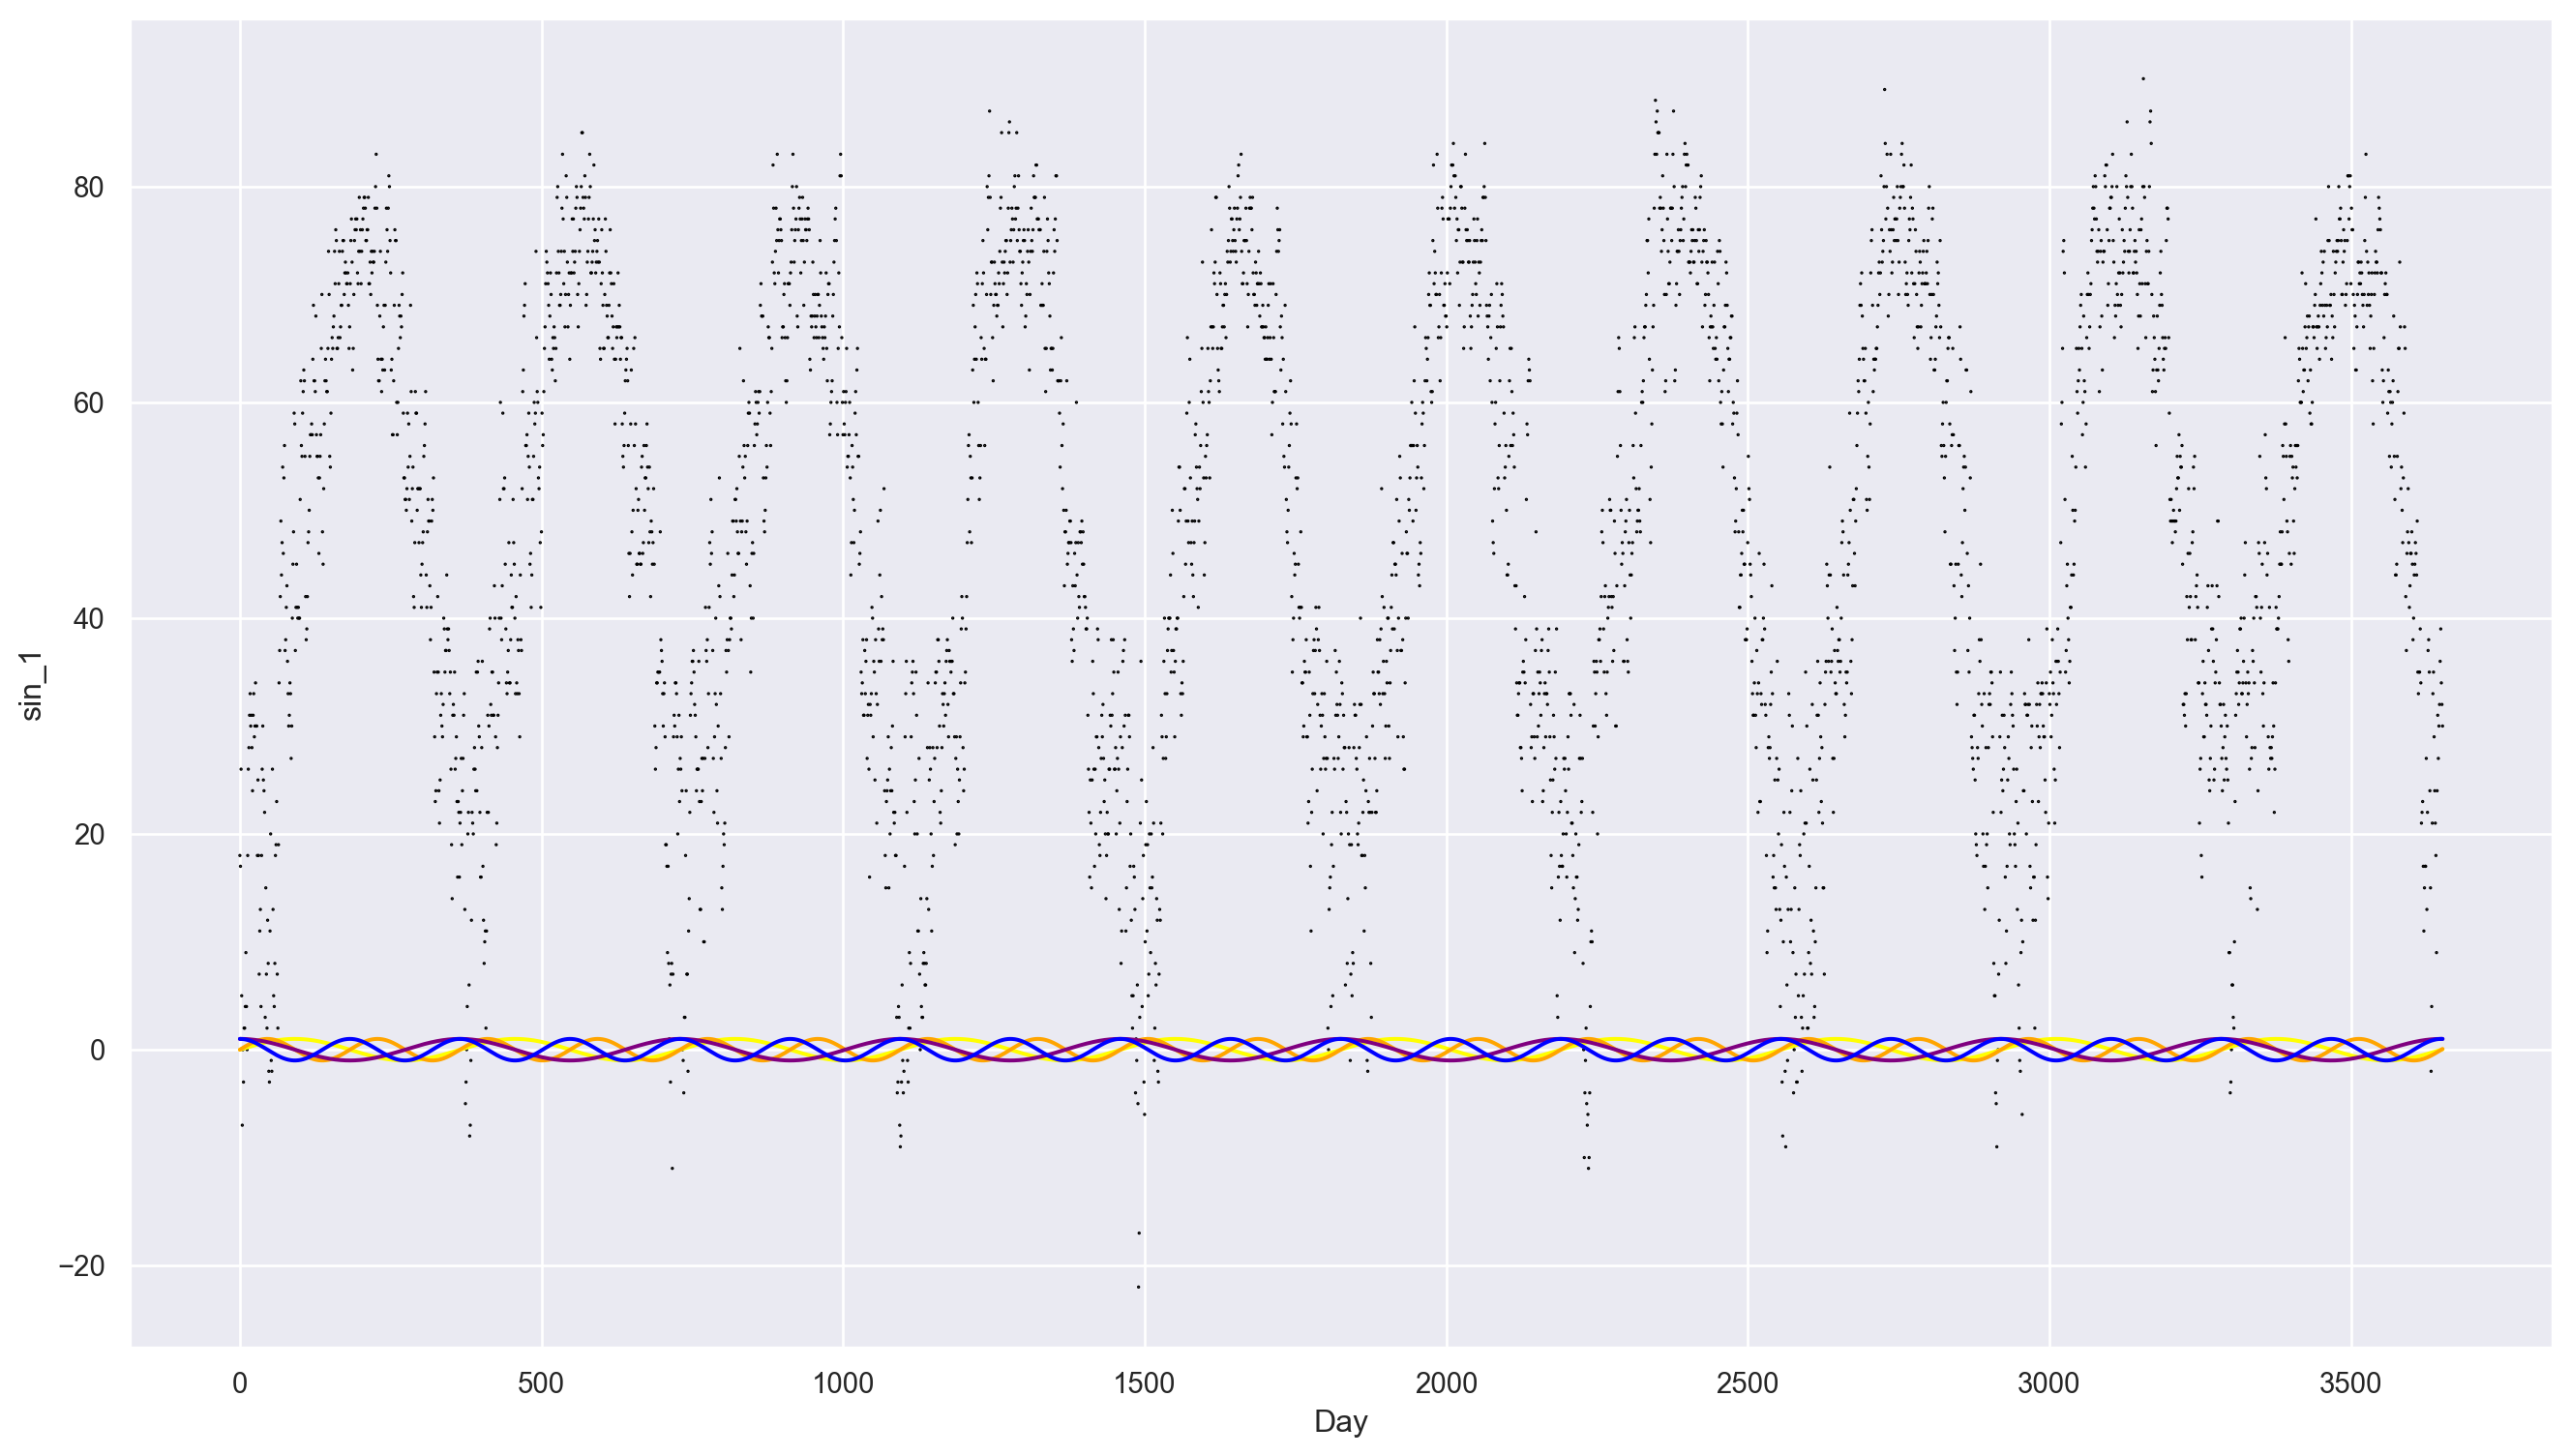

In [ ]:
def add_fourier(df, period= 365, order= 2):
    df = df.copy()
    for k in range(1, order + 1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['Day'] / period)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['Day'] / period)
    return df

add_fourier(excluded_regr_df)

count_plots = (
    so.Plot(add_fourier(excluded_regr_df), "Day")
    .add(so.Line(color= "yellow"), y= "sin_1")
    .add(so.Line(color= "orange"), y= "sin_2")
    .add(so.Line(color= "purple"), y= "cos_1")
    .add(so.Line(color= "blue"), y= "cos_2")
    #.add(so.Dots(color= "black", pointsize= .5), y= "TAVG")
    .layout(size=(14,8))
)
count_plots

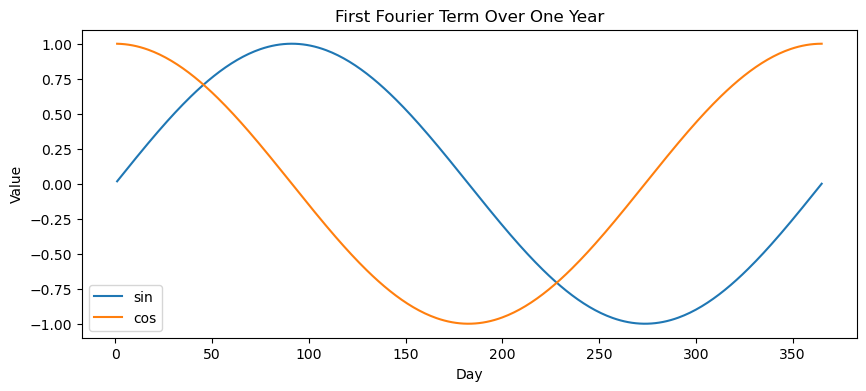

In [3]:
period = 365
days = np.arange(1, period + 1)  # Day 1 to Day 365

sine_wave = np.sin(2 * np.pi * days / period)
cosine_wave = np.cos(2 * np.pi * days / period)

plt.figure(figsize=(10, 4))
plt.plot(days, sine_wave, label='sin')
plt.plot(days, cosine_wave, label='cos')
plt.title('First Fourier Term Over One Year')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()